<a href="https://colab.research.google.com/github/Agnes-FD/Agnes-FD/blob/main/Model_CNN20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/data'

/content/drive/MyDrive/data


In [3]:
ls

with_mask/  without_mask/


In [4]:
import os
path = '/content/drive/MyDrive/data'
# Membuat Label pada gambar berdasarkan klasifikasi
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(path):
  for name in files:
    full_path.append(os.path.join(path, name))
    tag.append(path.split('/')[-1])
    file_name.append(name)

In [5]:
# Membuat dataframe berdasarkan hasil klasifikasi data yang sudah diberi label
import pandas as pd

df = pd.DataFrame({"path":full_path, "file_name": file_name, "tag":tag})
df.groupby(['tag']).size()

tag
with_mask       3725
without_mask    3828
dtype: int64

In [6]:
# cek data yang sudah diberi label
df

,path,file_name,tag
0,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask_3380.jpg,with_mask
1,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask_3479.jpg,with_mask
2,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask_3383.jpg,with_mask
3,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask_3488.jpg,with_mask
4,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask_335.jpg,with_mask
...,...,...,...
7548,/content/drive/MyDrive/data/without_mask/witho...,without_mask_2487.jpg,without_mask
7549,/content/drive/MyDrive/data/without_mask/witho...,without_mask_1345.jpg,without_mask
7550,/content/drive/MyDrive/data/without_mask/witho...,without_mask_190.jpg,without_mask
7551,/content/drive/MyDrive/data/without_mask/witho...,without_mask_238.jpg,without_mask


In [7]:
# Membagi dataset menjadi tiga bagian (train, test, dan vaidation)
from sklearn.model_selection import train_test_split

x = df['path']
y = df['tag']

x_train, x_test, y_train, y_test = train_test_split(
    x,y, test_size= 0.20, random_state=300)
x_test, x_val, y_test, y_val = train_test_split(
    x_test,y_test, test_size=0.5, random_state=100
)

In [8]:
# menyatukan kedalam masing-masing dataframe
df_test = pd.DataFrame({
    'path' : x_test,
    'tag' : y_test,
    'set' : 'test'
})

df_train = pd.DataFrame({
    'path' : x_train,
    'tag' : y_train,
    'set' : 'train'
})
df_val = pd.DataFrame({
    'path' : x_val,
    'tag' : y_val,
    'set' : 'validation'
})

In [9]:
print('train size', len(df_train))
print('test size', len(df_test))
print('validation size', len(df_val))

train size 6042
test size 755
validation size 756


In [10]:
# melihat masing-masing dataset apakah sudah sesuai atau belum
df_all = df_train.append([df_test, df_val]).reset_index(drop=1)

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

df_all.sample(4)


set         tag         
test        with_mask        367
            without_mask     388
train       with_mask       2986
            without_mask    3056
validation  with_mask        372
            without_mask     384
dtype: int64 




,path,tag,set
1366,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask,train
4019,/content/drive/MyDrive/data/without_mask/witho...,without_mask,train
3829,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask,train
940,/content/drive/MyDrive/data/without_mask/witho...,without_mask,train


In [11]:
# Memindahkan dataset
import shutil
from tqdm.notebook import tqdm as tq

In [12]:
datasource_path = '/content/drive/MyDrive/data'
dataset_path = '/content/drive/MyDrive/dataset'

In [13]:
for index, row in tq(df_all.iterrows()):
  file_path = row['path']

  if os.path.exists(file_path) == False:
    file_path = os.path.join(datasource_path, row['tag'], row['image'].split('.')[0])

  if os.path.exists(os.path.join(dataset_path, row['set'], row['tag'])) == False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['tag']))
  
  destination_file_name = file_path.split('/')[-1]
  file_dest = os.path.join(dataset_path, row['set'], row['tag'], destination_file_name)

  if os.path.exists(file_dest) == False:
    shutil.copy2(file_path, file_dest)

In [22]:
# Define Directory
base_dir = '/content/drive/MyDrive/dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'validation')

In [23]:
os.listdir(train_dir)

['with_mask', 'without_mask']

In [24]:
os.listdir(test_dir)

['with_mask', 'without_mask']

In [25]:
os.listdir(val_dir)

['with_mask', 'without_mask']

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.image as mpimg
import os
import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Dropout, UpSampling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.datasets import cifar10
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from IPython.display import Image, display
import random, os

In [28]:
def display20randomimages(t):
  fig=plt.figure(figsize=(8, 8))
  columns = 4
  rows = 5
  for i in range(1, columns*rows +1):
    c = "/" + str(random.choice(['with_mask/'])) + "/"
    random_filename = random.choice([
        x for x in os.listdir(t + c)
        if os.path.isfile(os.path.join(t+c, x))
    ])
    img = mpimg.imread(t+c+random_filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
  plt.show()



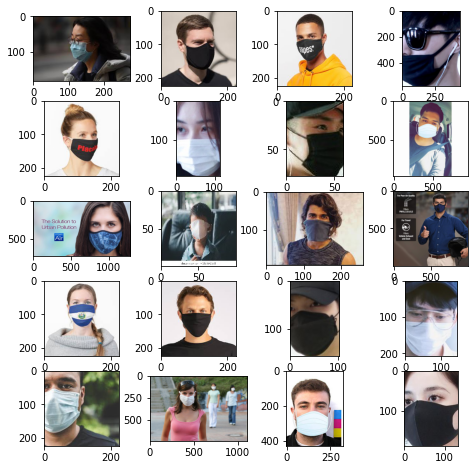

In [29]:
display20randomimages('/content/drive/MyDrive/data')

In [30]:
def display20randomimages(t):
  fig=plt.figure(figsize=(8, 8))
  columns = 4
  rows = 5
  for i in range(1, columns*rows +1):
    c = "/" + str(random.choice(['without_mask/'])) + "/"
    random_filename = random.choice([
        x for x in os.listdir(t + c)
        if os.path.isfile(os.path.join(t+c, x))
    ])
    img = mpimg.imread(t+c+random_filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
  plt.show()

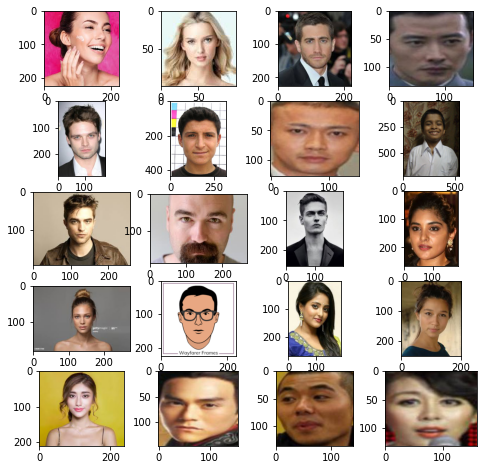

In [34]:
display20randomimages('/content/drive/MyDrive/data')

In [35]:
#train test split
from sklearn.model_selection import train_test_split

In [36]:
train_without_mask_dir = os.path.join(train_dir, 'without_mask')
train_with_mask_dir = os.path.join(train_dir, 'with_mask')
test_without_mask_dir = os.path.join(test_dir, 'without_mask')
test_with_mask_dir = os.path.join(test_dir, 'with_mask')
val_without_mask_dir = os.path.join(val_dir, 'without_mask')
val_with_mask_dir = os.path.join(val_dir, 'with_mask')

In [37]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.5.0


In [38]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'binary'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size = (256,256),
    batch_size = 32,
    class_mode = 'binary'
)
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'binary'
)

Found 6042 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.
Found 756 images belonging to 2 classes.


In [43]:
# Membuat Model CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_cnn = Sequential()
model_cnn.add(Conv2D(32,(3,3), activation= 'relu', name='conv_1', input_shape=(256,256,3)))
model_cnn.add(MaxPooling2D((2,2), name='maxpool_1'))
model_cnn.add(Conv2D(64,(3,3),activation='relu', name='conv_2'))
model_cnn.add(MaxPooling2D((2,2), name='maxpool_2'))
model_cnn.add(Conv2D(128,(3,3),activation='relu', name='conv_3'))
model_cnn.add(MaxPooling2D((2,2), name='maxpool_3'))
model_cnn.add(Conv2D(256,(3,3),activation='relu' ,name='conv_4'))
model_cnn.add(MaxPooling2D((2,2), name='maxpool_4'))
model_cnn.add(Conv2D(256,(3,3),activation='relu' ,name='conv_5'))
model_cnn.add(MaxPooling2D((2,2), name='maxpool_5'))

model_cnn.add(Flatten())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(256, activation='relu', name= 'dense_2'))
model_cnn.add(Dense(1, activation='sigmoid', name= 'output'))

model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 127, 127, 32)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 125, 125, 64)      18496     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 62, 62, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 60, 60, 128)       73856     
_________________________________________________________________
maxpool_3 (MaxPooling2D)     (None, 30, 30, 128)       0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 28, 28, 256)      

In [44]:
print('Compiling Model.......')
model_cnn.compile (optimizer='Adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

Compiling Model.......


In [45]:
import tensorflow as tf

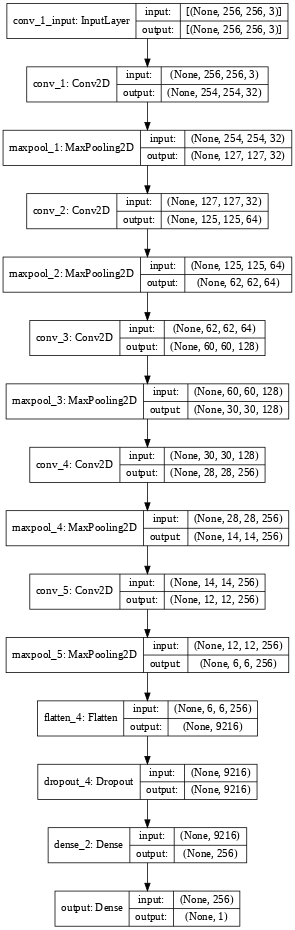

In [46]:
model_viz = tf.keras.utils.plot_model(model_cnn,
                                      to_file='/content/drive/MyDrive/Colab Notebooks/model20.png',
                                      show_shapes=True,
                                      rankdir='TB',
                                      expand_nested=True,
                                      dpi=55)
model_viz

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97):
      print('Akurasi mencapai 97%, proses training dihentikan!')
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history_cnn = model_cnn.fit(
    train_generator,
    steps_per_epoch = 50,
    epochs = 250,
    validation_data = test_generator,
    validation_steps = 10,
    callbacks = [callbacks]
)

Epoch 1/250
22/50 [============>.................] - ETA: 5:38 - loss: 0.7072 - accuracy: 0.4958

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


50/50 [==============================] - 712s 14s/step - loss: 0.7024 - accuracy: 0.5051 - val_loss: 0.6923 - val_accuracy: 0.5656
Epoch 2/250
50/50 [==============================] - 565s 11s/step - loss: 0.6927 - accuracy: 0.5164 - val_loss: 0.6939 - val_accuracy: 0.3969
Epoch 3/250
50/50 [==============================] - 463s 9s/step - loss: 0.6953 - accuracy: 0.4664 - val_loss: 0.6909 - val_accuracy: 0.5625
Epoch 4/250
50/50 [==============================] - 391s 8s/step - loss: 0.6942 - accuracy: 0.4969 - val_loss: 0.6906 - val_accuracy: 0.6344
Epoch 5/250
50/50 [==============================] - 327s 6s/step - loss: 0.6238 - accuracy: 0.6626 - val_loss: 0.5172 - val_accuracy: 0.7844
Epoch 6/250
50/50 [==============================] - 311s 6s/step - loss: 0.4980 - accuracy: 0.7947 - val_loss: 0.3462 - val_accuracy: 0.8813
Epoch 7/250
50/50 [==============================] - 297s 6s/step - loss: 0.3226 - accuracy: 0.8908 - val_loss: 0.2785 - val_accuracy: 0.8844
Epoch 8/250
50/5

In [ ]:
from matplotlib import pyplot as plt

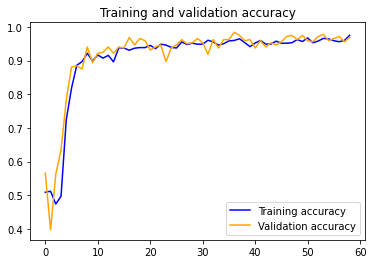

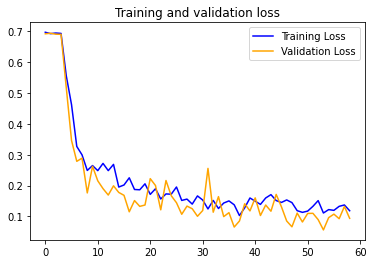

In [ ]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'blue', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#save model
import os

In [ ]:
cd'/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [ ]:
MODEL_BASE_PATH = "Model"
PROJECT_NAME ="CNN"
SAVE_MODEL_NAME = "Model_CNN20.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model_cnn.save(save_model_path,include_optimizer=False)

Saving Model At Model/CNN/Model_CNN20.h5...


# Bagian Baru